# Lab4: Quantize DeiT

### Setup

Install the newest version of torch, torchvision, and timm.

In [18]:
# install the newest version of torch, torchvision, and timm
# !pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata timm
# !pip3 install torch torchaudio torchvision torchtext torchdata timm

Import Required Libraries

In [33]:
import numpy as np
import torch
from torch import nn
import os
from tqdm.auto import tqdm
import math
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import DataLoader

from torch.export import export, ExportedProgram
from torchvision.models.mobilenetv2 import MobileNet_V2_Weights
from torch._export import capture_pre_autograd_graph
from torch.ao.quantization.quantize_pt2e import convert_pt2e, prepare_pt2e, prepare_qat_pt2e
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
    get_symmetric_quantization_config,
    XNNPACKQuantizer,
)
torch.cuda.is_available()

True

Preparing Dataset

In [20]:
def data_loader_to_list(data_loader, length=128):
    new_data_loader = []
    if length < 0:
        return list(data_loader)
    else:
        for i, data in enumerate(data_loader):
            if i >= length:
                break
            new_data_loader.append(data)

    return new_data_loader

def build_dataset_CIFAR100(is_train, data_path):
    transform = build_transform(is_train)
    dataset = datasets.CIFAR100(data_path, train=is_train, transform=transform, download=True)
    nb_classes = 100
    return dataset, nb_classes

def build_transform(is_train):
    input_size = 224
    eval_crop_ratio = 1.0

    resize_im = input_size > 32
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=input_size,
            is_training=True,
            color_jitter=0.3,
            auto_augment='rand-m9-mstd0.5-inc1',
            interpolation='bicubic',
            re_prob=0.0,
            re_mode='pixel',
            re_count=1,
        )
        if not resize_im:
            # replace RandomResizedCropAndInterpolation with
            # RandomCrop
            transform.transforms[0] = transforms.RandomCrop(
                input_size, padding=4)
        return transform

    t = []
    if resize_im:
        size = int(input_size / eval_crop_ratio)
        t.append(
            transforms.Resize(size, interpolation=3),  # to maintain same ratio w.r.t. 224 images
        )
        t.append(transforms.CenterCrop(input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
    return transforms.Compose(t)

def prepare_data(batch_size):
    train_set, nb_classes = build_dataset_CIFAR100(is_train=True, data_path='./data')
    test_set, _ = build_dataset_CIFAR100(is_train=False, data_path='./data')

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader, test_loader, nb_classes


Training and Calibration

In [21]:
def calibrate(model: nn.Module, data_loader) -> None:
    calibration_data = data_loader_to_list(data_loader, math.ceil(128/data_loader.batch_size)) # calibrate 128 images
    for image, _ in calibration_data:
        model(image)
    return

def train_one_epoch(model, criterion, optimizer, data_loader, device):
    cnt = 0
    for image, target in tqdm(data_loader):
        cnt += 1
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Evaluation

In [22]:
def get_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    model_size = os.path.getsize("temp.p")/1e6
    os.remove('temp.p')
    return model_size

def evaluate_model(model, data_loader, device):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy}%')
    return accuracy

def getMiniTestDataset():
    # Create a test_loader with batch size = 1
    _, test_loader, _ = prepare_data(batch_size=1)

    # Prepare to collect 10 images per class
    class_images = [[] for _ in range(100)]

    # Iterate through the data
    for (image, label) in test_loader:
        if len(class_images[label]) < 5:
            class_images[label].append((image, label))
        if all(len(images) == 5 for images in class_images):
            break  # Stop once we have 10 images per class

    # flatten class_images
    mini_test_dataset = []
    for images in class_images:
        mini_test_dataset.extend(images)
    return mini_test_dataset

# TA Uses the following code to evaluate your score
def lab4_cifar100_evaluation(quantized_model_path='deits_quantized.pth'):
    # Prepare data
    mini_test_dataset = getMiniTestDataset()

    # Load quantized model
    quantized_ep = torch.export.load(quantized_model_path)
    quantized_model = quantized_ep.module()

    # Evaluate model
    start_time = time.time()
    acc = evaluate_model(quantized_model, mini_test_dataset, device="cpu")
    exec_time = time.time() - start_time
    model_size = get_size_of_model(quantized_model)

    print(f"Model Size: {model_size:.2f} MB")
    print(f"Accuracy: {acc:.2f}%")
    print(f"Execution Time: {exec_time:.2f} s")

    score = 0
    if model_size <= 30: score += 10
    if model_size <= 27: score += 2 * math.floor(27-model_size)
    if acc >= 86:
      score += 10 + 2 * math.floor(acc-86)
    print(f'Model Score: {score:.2f}')
    return score

## Part1: Simple Quantization Pipeline (0%)

Below is a naive pipeline of quantizing DeiT-S. You may need to modify the pipeline or build your own later on.

[**use_reference_representation=False** in **convert_pt2e()** represents fake quant (matmul using fp32).](https://pytorch.org/tutorials/prototype/pt2e_quant_ptq_static.html#convert-the-calibrated-model-to-a-quantized-model)

However when the variable is set to True, the execution speed becomes extremely slow.

In this lab, it is just fine to set **use_reference_representation=False**.

In [23]:
from torch.export import Dim
from torch._export import capture_pre_autograd_graph

def quantize_ptq_model(model: nn.Module, data_loader, per_channel=False) -> None:
    # captuer model graph
    _dummy_input_data = (next(iter(data_loader))[0],)
    model.eval()
    dynamic_shapes = {"x": {0: Dim("batch")}} # to allow diffent batch size on training/inference
    model = capture_pre_autograd_graph(model, _dummy_input_data, dynamic_shapes=dynamic_shapes)

    # Init quantizer
    quantizer = XNNPACKQuantizer()
    quantization_config = get_symmetric_quantization_config(is_per_channel=per_channel, is_qat=False)
    quantizer.set_global(quantization_config)

    # Prepare model for quantization
    model = prepare_pt2e(model, quantizer)

    # Calibration
    calibrate(model, data_loader)

    # Convert model to quantized model
    model = convert_pt2e(model, use_reference_representation=False)
    return model

In [24]:
# Load the model
batch_size = 32 # Use batch size > 1 for faster PTQ and QAT.
model = torch.load('0.9099_deit3_small_patch16_224.pth', map_location='cpu')
train_loader, test_loader, _ = prepare_data(batch_size)

# We use only a porpotion of test dataset for evaluation, with batch size = 1 for inference.
mini_test_dataset = getMiniTestDataset()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [25]:
# evaluate before quantization
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
acc = evaluate_model(model, mini_test_dataset, device)
print('Size (MB) before quantization:', get_size_of_model(model))
print(f'Accuracy of the model on the test images: {acc}%') # 92.8%

# quantize model
print('Quantizing model...')
model.cpu()
quantized_model = quantize_ptq_model(model, train_loader, per_channel=False)
torch.ao.quantization.move_exported_model_to_eval(quantized_model)

print('Exporting model...')
quantized_model_path = "deits_quantized.pth"

quantized_model.cpu()
cpu_example_inputs = (torch.randn([1, 3, 224, 224]), ) # batch_size should equal to 1 on inference.
quantized_ep = torch.export.export(quantized_model, cpu_example_inputs)
torch.export.save(quantized_ep, quantized_model_path)

print('Evaluating model...')
lab4_cifar100_evaluation(quantized_model_path) # 84.4%

100%|██████████| 500/500 [00:02<00:00, 176.03it/s]


Accuracy of the model on the test images: 93.6%
Size (MB) before quantization: 86.905654
Accuracy of the model on the test images: 93.6%
Quantizing model...
Exporting model...
Evaluating model...
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:40<00:00, 12.38it/s]

Accuracy of the model on the test images: 85.6%
Model Size: 21.94 MB
Accuracy: 85.60%
Execution Time: 40.40 s
Model Score: 20.00


20

# Below are some tools that may be useful in this lab:

## Profiling Models

The code below profiles your model, and generates a trace file for you to find out what is going on in your model throughout the execution.

The generated trace file will be named *(test_trace_*.json)*, in the same directory as the notebook. To visualize, go to page [chrome://tracing](chrome://tracing) in either Chrome or Edge browser, then upload the trace file.

In [26]:
# profile model
from torch.profiler import profile, record_function, ProfilerActivity

# ## Default way to use profiler
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
#     for _ in range(10):
#         a = torch.square(torch.randn(10000, 10000).cuda())

# prof.export_chrome_trace("trace.json")

def torch_profile(model, input_data, device):
  ## With warmup and skip
  # https://pytorch.org/docs/stable/profiler.html

  # Non-default profiler schedule allows user to turn profiler on and off
  # on different iterations of the training loop;
  # trace_handler is called every time a new trace becomes available
  def trace_handler(prof):
    print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))
    prof.export_chrome_trace("./test_trace_" + str(prof.step_num) + ".json")

  with torch.profiler.profile(
    activities=[
      torch.profiler.ProfilerActivity.CPU,
      torch.profiler.ProfilerActivity.CUDA,
    ],

    # In this example with wait=1, warmup=1, active=2, repeat=1,
    # profiler will skip the first step/iteration,
    # start warming up on the second, record
    # the third and the forth iterations,
    # after which the trace will become available
    # and on_trace_ready (when set) is called;
    # the cycle repeats starting with the next step
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=2, repeat=1),
    on_trace_ready=trace_handler
    # on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
    # used when outputting for tensorboard
    ) as p:
      for data in input_data:
        model(data.to(device))
        # send a signal to the profiler that the next iteration has started
        p.step()

In [27]:
dummy_input_data = [next(iter(test_loader))[0] for _ in range(3)]
device = torch.device("cpu")

# Load quantized model
quantized_ep = torch.export.load(quantized_model_path)
loaded_quantized_model = quantized_ep.module()
# profile quantized model
# torch_profile(loaded_quantized_model, dummy_input_data, device)

## To obtain specific model layers

In [28]:
def match_string(string, match_list, match_prefix=False, match_suffix=False):
    if match_prefix:
        return any(string.startswith(s) for s in match_list)
    elif match_suffix:
        return any(string.endswith(s) for s in match_list)
    else:
        return any(s in string for s in match_list)

def get_model_layers(model, match_names=None, match_types=None, prefix=''):
    matching_layers = []
    for name, module in model.named_modules():
        if match_names is None or match_string(name, match_names):
            if match_types is None or match_string(type(module).__name__, match_types):
                matching_layers.append((f'{prefix}{name}', module))
    return matching_layers

layer_names = [f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2']
block0_layers = get_model_layers(model, match_names=layer_names, match_types=['Linear'])

print(block0_layers)

[('blocks.0.attn.qkv', Linear(in_features=384, out_features=1152, bias=True)), ('blocks.0.mlp.fc1', Linear(in_features=384, out_features=1536, bias=True)), ('blocks.0.mlp.fc2', Linear(in_features=1536, out_features=384, bias=True))]


## To capture the output of each layer


In [29]:
class HookHandler:
    def __init__(self):
        self.handlers = []

    def __del__(self):
        self.remove_hooks()

    def _generate_hook(self, apply_func, key, layer_data_dict: dict):
        def hook_fn(model, input, output):
            nonlocal layer_data_dict
            layer_data_dict[key] = apply_func(
                output, layer_data_dict.get(key, None))
        return hook_fn

    def _bind_hooks(self, apply_layers, apply_func, layer_data_dict: dict):
        for name, module in apply_layers:
            hook_fn = self._generate_hook(apply_func, name, layer_data_dict)
            self.handlers.append(module.register_forward_hook(hook_fn))

    def create_hooks(self, apply_layers, apply_func, layer_data_dict: dict):
        self._bind_hooks(apply_layers, apply_func, layer_data_dict)

    def remove_hooks(self):
        for handle in self.handlers:
            handle.remove()
        self.handlers = []

def absmax(data, axis=None):
    p_data = data.max(axis=axis)
    n_data = data.min(axis=axis)
    return np.where(abs(p_data) > abs(n_data), p_data, n_data)

def get_flat_act_func(new_val: torch.Tensor, _):
    return new_val.cpu().detach().numpy().flatten()


def get_act_func(new_val: torch.Tensor, _):
    return new_val.cpu().detach().numpy()


def get_avg_act_func(new_val: torch.Tensor, existing_val):
    if existing_val is None:
        avg = new_val.cpu().detach().numpy().sum(axis=0) / total_cnt
        total_cnt = new_val.shape[0]

    else:
        total_cnt, avg = existing_val.get("total_cnt"), existing_val.get("value")
        avg = (avg * total_cnt + new_val.cpu().detach().numpy().sum(axis=0)) / (total_cnt + new_val.shape[0])
        total_cnt += new_val.shape[0]

    return {"total_cnt": total_cnt, "value": avg}

def get_absmax_act_func(new_val: torch.Tensor, existing_val):
    new_absmax = absmax(new_val.cpu().detach().numpy(), axis=0)
    if existing_val is None:
        value = new_absmax
    else:
        value = absmax(np.stack([existing_val, new_absmax], axis=0), axis=0)
    return value

In [30]:
# initialize HookHandler and the dictionary to store the outputs
handler = HookHandler()
layer_outputs = {}

# get the layers you want to record
layer_names = [f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2']
block0_layers = get_model_layers(model, match_names=layer_names, match_types=['Linear'])

# create hooks for the layers (<layers>, <hook function>, <dictionary to store the outputs>)
handler.create_hooks(block0_layers, get_act_func, layer_outputs)

# calibrate the model and record the outputs
with torch.autocast(device_type="cuda"):
    for i, (image, _) in enumerate(train_loader):
        if i >= 128: break
        model(image)

# remove the hooks
handler.remove_hooks()

print(layer_outputs)

{'blocks.0.attn.qkv': array([[[ 1.59870553e+00,  2.75408804e-01,  1.87410533e-01, ...,
          8.06937516e-02,  1.31315753e-01,  1.55662283e-01],
        [ 9.91983533e-01, -2.18606874e-01, -5.05628809e-02, ...,
          4.99717951e-01, -3.31286550e-01, -8.79114866e-02],
        [ 9.50055361e-01, -2.14124367e-01,  1.91505793e-02, ...,
          4.89995927e-01, -3.06027234e-01, -6.71661198e-02],
        ...,
        [ 1.15747249e+00,  4.84104678e-02, -1.98423564e-02, ...,
          5.16963840e-01, -6.62800968e-02, -1.13873877e-01],
        [ 1.14898777e+00,  6.29282147e-02, -4.02429104e-02, ...,
          5.25297821e-01, -1.03001356e-01, -1.18097126e-01],
        [ 1.18697596e+00,  2.30900347e-02, -9.81061459e-02, ...,
          5.61977088e-01, -1.03715703e-01, -1.19791701e-01]],

       [[ 1.59870553e+00,  2.75408804e-01,  1.87410533e-01, ...,
          8.06937516e-02,  1.31315753e-01,  1.55662283e-01],
        [ 1.88707948e+00, -2.16524899e-01,  1.44112995e-02, ...,
         -2.7532

## To ignore specific layers for quantization:
([xnnpack source code](https://github.com/pytorch/pytorch/blob/main/torch/ao/quantization/quantizer/xnnpack_quantizer.py\), also you can try messing around with the Observer classes)

In [31]:
# Replace functions XNNPackQuantizer uses for annotation.

def get_module_names(name):
    names = name.split(".")
    return [".".join(names[i:]) for i in reversed(range(len(names)))]

def parse_string(name):
    if name.startswith("L"): return name[10:]
    split_getattr = name.split(")")
    ig_left = split_getattr[0].split("L['self'].")[-1].split(",")[0]
    ig_right = split_getattr[0].split(", '")[-1][:-1]
    return ig_left + "." + str(ig_right) + split_getattr[1]

def is_name_in_ignore_list(name, IGNORE_LIST):
    return name in IGNORE_LIST

def name_not_in_ignore_list(n, IGNORE_LIST) -> bool:
    nn_module_stack = n.meta.get("nn_module_stack", {})
    names = [n for n, klass in nn_module_stack.values()]
    if len(names) == 0:
        return True

    names = get_module_names(parse_string(names[-1]))
    set1 = set(names)
    set2 = set(IGNORE_LIST)
    # if len(set1.intersection(set2)) == 0:
    #     print("DEBUG: ", names)
    return len(set1.intersection(set2)) == 0

def get_module_name_filter(module_name: str, IGNORE_LIST):
    def module_name_filter(n) -> bool:
        nn_module_stack = n.meta.get("nn_module_stack", {})
        names = [n for n, klass in nn_module_stack.values()]
        if len(names) == 0:
            return False

        names = get_module_names(parse_string(names[-1]))
        return (module_name in names) and name_not_in_ignore_list(n, IGNORE_LIST)
    return module_name_filter


def get_module_type_filter(tp, IGNORE_LIST):
    def module_type_filter(n) -> bool:
        nn_module_stack = n.meta.get("nn_module_stack", {})
        types = [t for _, t in nn_module_stack.values()]
        return (tp in types) and name_not_in_ignore_list(n, IGNORE_LIST)

    return module_type_filter


def get_not_module_type_or_name_filter(
    tp_list, module_name_list, IGNORE_LIST
):
    module_type_filters = [get_module_type_filter(tp) for tp in tp_list]
    module_name_list_filters = [get_module_name_filter(m) for m in module_name_list]

    def not_module_type_or_name_filter(n) -> bool:
        return not any(f(n) for f in module_type_filters + module_name_list_filters) and name_not_in_ignore_list(n, IGNORE_LIST)

    return not_module_type_or_name_filter

class PartialXNNPACKQuantizer(XNNPACKQuantizer): # skips quantizing layers inside the ignore_list
    def __init__(self, ignore_list):
        super().__init__()
        self.ignore_list = ignore_list

    def _annotate_for_static_quantization_config(
        self, model: torch.fx.GraphModule
    ) -> torch.fx.GraphModule:
        print("annotating for static quantization")
        module_name_list = list(self.module_name_config.keys())
        for module_name, config in self.module_name_config.items():
            self._annotate_all_static_patterns(
                model, config, get_module_name_filter(module_name, self.ignore_list)
            )

        tp_list = list(self.module_type_config.keys())
        for module_type, config in self.module_type_config.items():
            self._annotate_all_static_patterns(
                model, config, get_module_type_filter(module_type, self.ignore_list)
            )

        self._annotate_all_static_patterns(
            model,
            self.global_config,
            get_not_module_type_or_name_filter(tp_list, module_name_list, self.ignore_list),
        )
        return model

    def _annotate_for_dynamic_quantization_config(
        self, model: torch.fx.GraphModule
    ) -> torch.fx.GraphModule:
        print("annotating for dynamic quantization")
        module_name_list = list(self.module_name_config.keys())
        for module_name, config in self.module_name_config.items():
            self._annotate_all_dynamic_patterns(
                model, config, get_module_name_filter(module_name, self.ignore_list)
            )

        tp_list = list(self.module_type_config.keys())
        for module_type, config in self.module_type_config.items():
            self._annotate_all_dynamic_patterns(
                model, config, get_module_type_filter(module_type, self.ignore_list)
            )

        self._annotate_all_dynamic_patterns(
            model,
            self.global_config,
            get_not_module_type_or_name_filter(tp_list, module_name_list, self.ignore_list),
        )
        return model

# quantizer = XNNPACKQuantizer()
quantizer = PartialXNNPACKQuantizer(ignore_list=["head"]) # replace XNNPACKQuantizer()

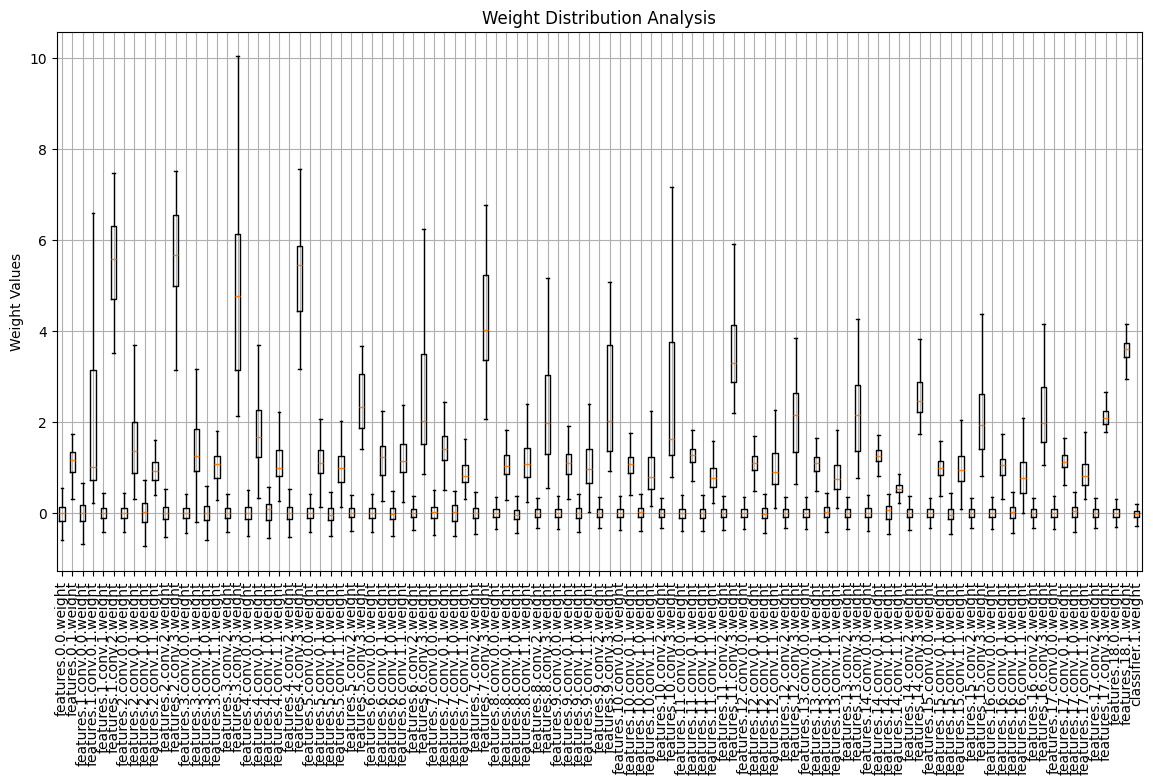

In [44]:
def extract_weights(model):
    weights = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights[name] = param.detach().cpu().numpy().flatten()
    return weights

def plot_weight_distribution(weights):
    # Prepare data for box plot
    data = [weights[name] for name in weights]
    labels = [name for name in weights]
    
    plt.figure(figsize=(14, 7))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.xticks(rotation=90)
    plt.title('Weight Distribution Analysis')
    plt.ylabel('Weight Values')
    plt.grid(True)
    plt.show()

model = torch.load('mobilenetv2_0.963.pth', map_location='cpu')
weights = extract_weights(model)
plot_weight_distribution(weights)


In [38]:
def decompose_min_difference(n):
    """
    Decomposes a given number 'n' into two numbers with minimal difference.

    Args:
        n (int): The input number to be decomposed.

    Returns:
        tuple: A tuple containing two numbers (x, y) such that x * y = n and abs(x - y) is minimized.
    """

    # Check for valid input
    if n <= 1:
        raise ValueError("Input number must be greater than 1")

    # Initialize variables
    min_diff = float('inf')
    best_x = None
    best_y = None

    # Iterate over possible values of x
    for x in range(2, int(n**0.5) + 1):
        if n % x == 0:
            y = n // x
            diff = abs(x - y)

            # Update best solution if current difference is smaller
            if diff < min_diff:
                min_diff = diff
                best_x = x
                best_y = y

    # Return the best solution
    return best_x, best_y

def plot_layer_output_dist(layer_outputs):
    # save each layer's outputs as a large image for visualization
    import matplotlib.pyplot as plt
    import os

    # create subplots to accommodate all the layers
    num_layer_outputs = len(layer_outputs)
    print(num_layer_outputs)
    plot_num = decompose_min_difference(num_layer_outputs)
    fig, axes = plt.subplots(plot_num[0], plot_num[1], figsize=(plot_num[1]*3, plot_num[0]*3))
    axes = axes.ravel()
    plot_index = 0

    # plot the outputs of each layer
    for layer_name, layer_output in layer_outputs.items():
        # plot histograms for the outputs of the linear layers
        axes[plot_index].hist(layer_output.flatten(), bins=100)
        axes[plot_index].set_title(layer_name)
        plot_index += 1

    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.savefig(os.path.join('activation.png'))

def plot_layer_output_minmax(layer_outputs):
    # plot the min and max values of each layer's output using box plot
    import matplotlib.pyplot as plt
    import os

    flat_layer_outputs = {layer_name: layer_output.flatten() for layer_name, layer_output in layer_outputs.items()}
    # draw box plot using test input
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 30)
    ax.boxplot(flat_layer_outputs.values(), vert=False, patch_artist=True, showmeans=True)
    ax.set_yticklabels(flat_layer_outputs.keys())
    plt.savefig(os.path.join('activation_minmax.png'))

['patch_embed', 'patch_embed.proj', 'patch_embed.norm', 'pos_drop', 'patch_drop', 'norm_pre', 'blocks', 'blocks.0', 'blocks.0.norm1', 'blocks.0.attn', 'blocks.0.attn.qkv', 'blocks.0.attn.q_norm', 'blocks.0.attn.k_norm', 'blocks.0.attn.attn_drop', 'blocks.0.attn.proj', 'blocks.0.attn.proj_drop', 'blocks.0.ls1', 'blocks.0.drop_path1', 'blocks.0.norm2', 'blocks.0.mlp', 'blocks.0.mlp.fc1', 'blocks.0.mlp.act', 'blocks.0.mlp.drop1', 'blocks.0.mlp.norm', 'blocks.0.mlp.fc2', 'blocks.0.mlp.drop2', 'blocks.0.ls2', 'blocks.0.drop_path2', 'blocks.1', 'blocks.1.norm1', 'blocks.1.attn', 'blocks.1.attn.qkv', 'blocks.1.attn.q_norm', 'blocks.1.attn.k_norm', 'blocks.1.attn.attn_drop', 'blocks.1.attn.proj', 'blocks.1.attn.proj_drop', 'blocks.1.ls1', 'blocks.1.drop_path1', 'blocks.1.norm2', 'blocks.1.mlp', 'blocks.1.mlp.fc1', 'blocks.1.mlp.act', 'blocks.1.mlp.drop1', 'blocks.1.mlp.norm', 'blocks.1.mlp.fc2', 'blocks.1.mlp.drop2', 'blocks.1.ls2', 'blocks.1.drop_path2', 'blocks.2', 'blocks.2.norm1', 'blocks.

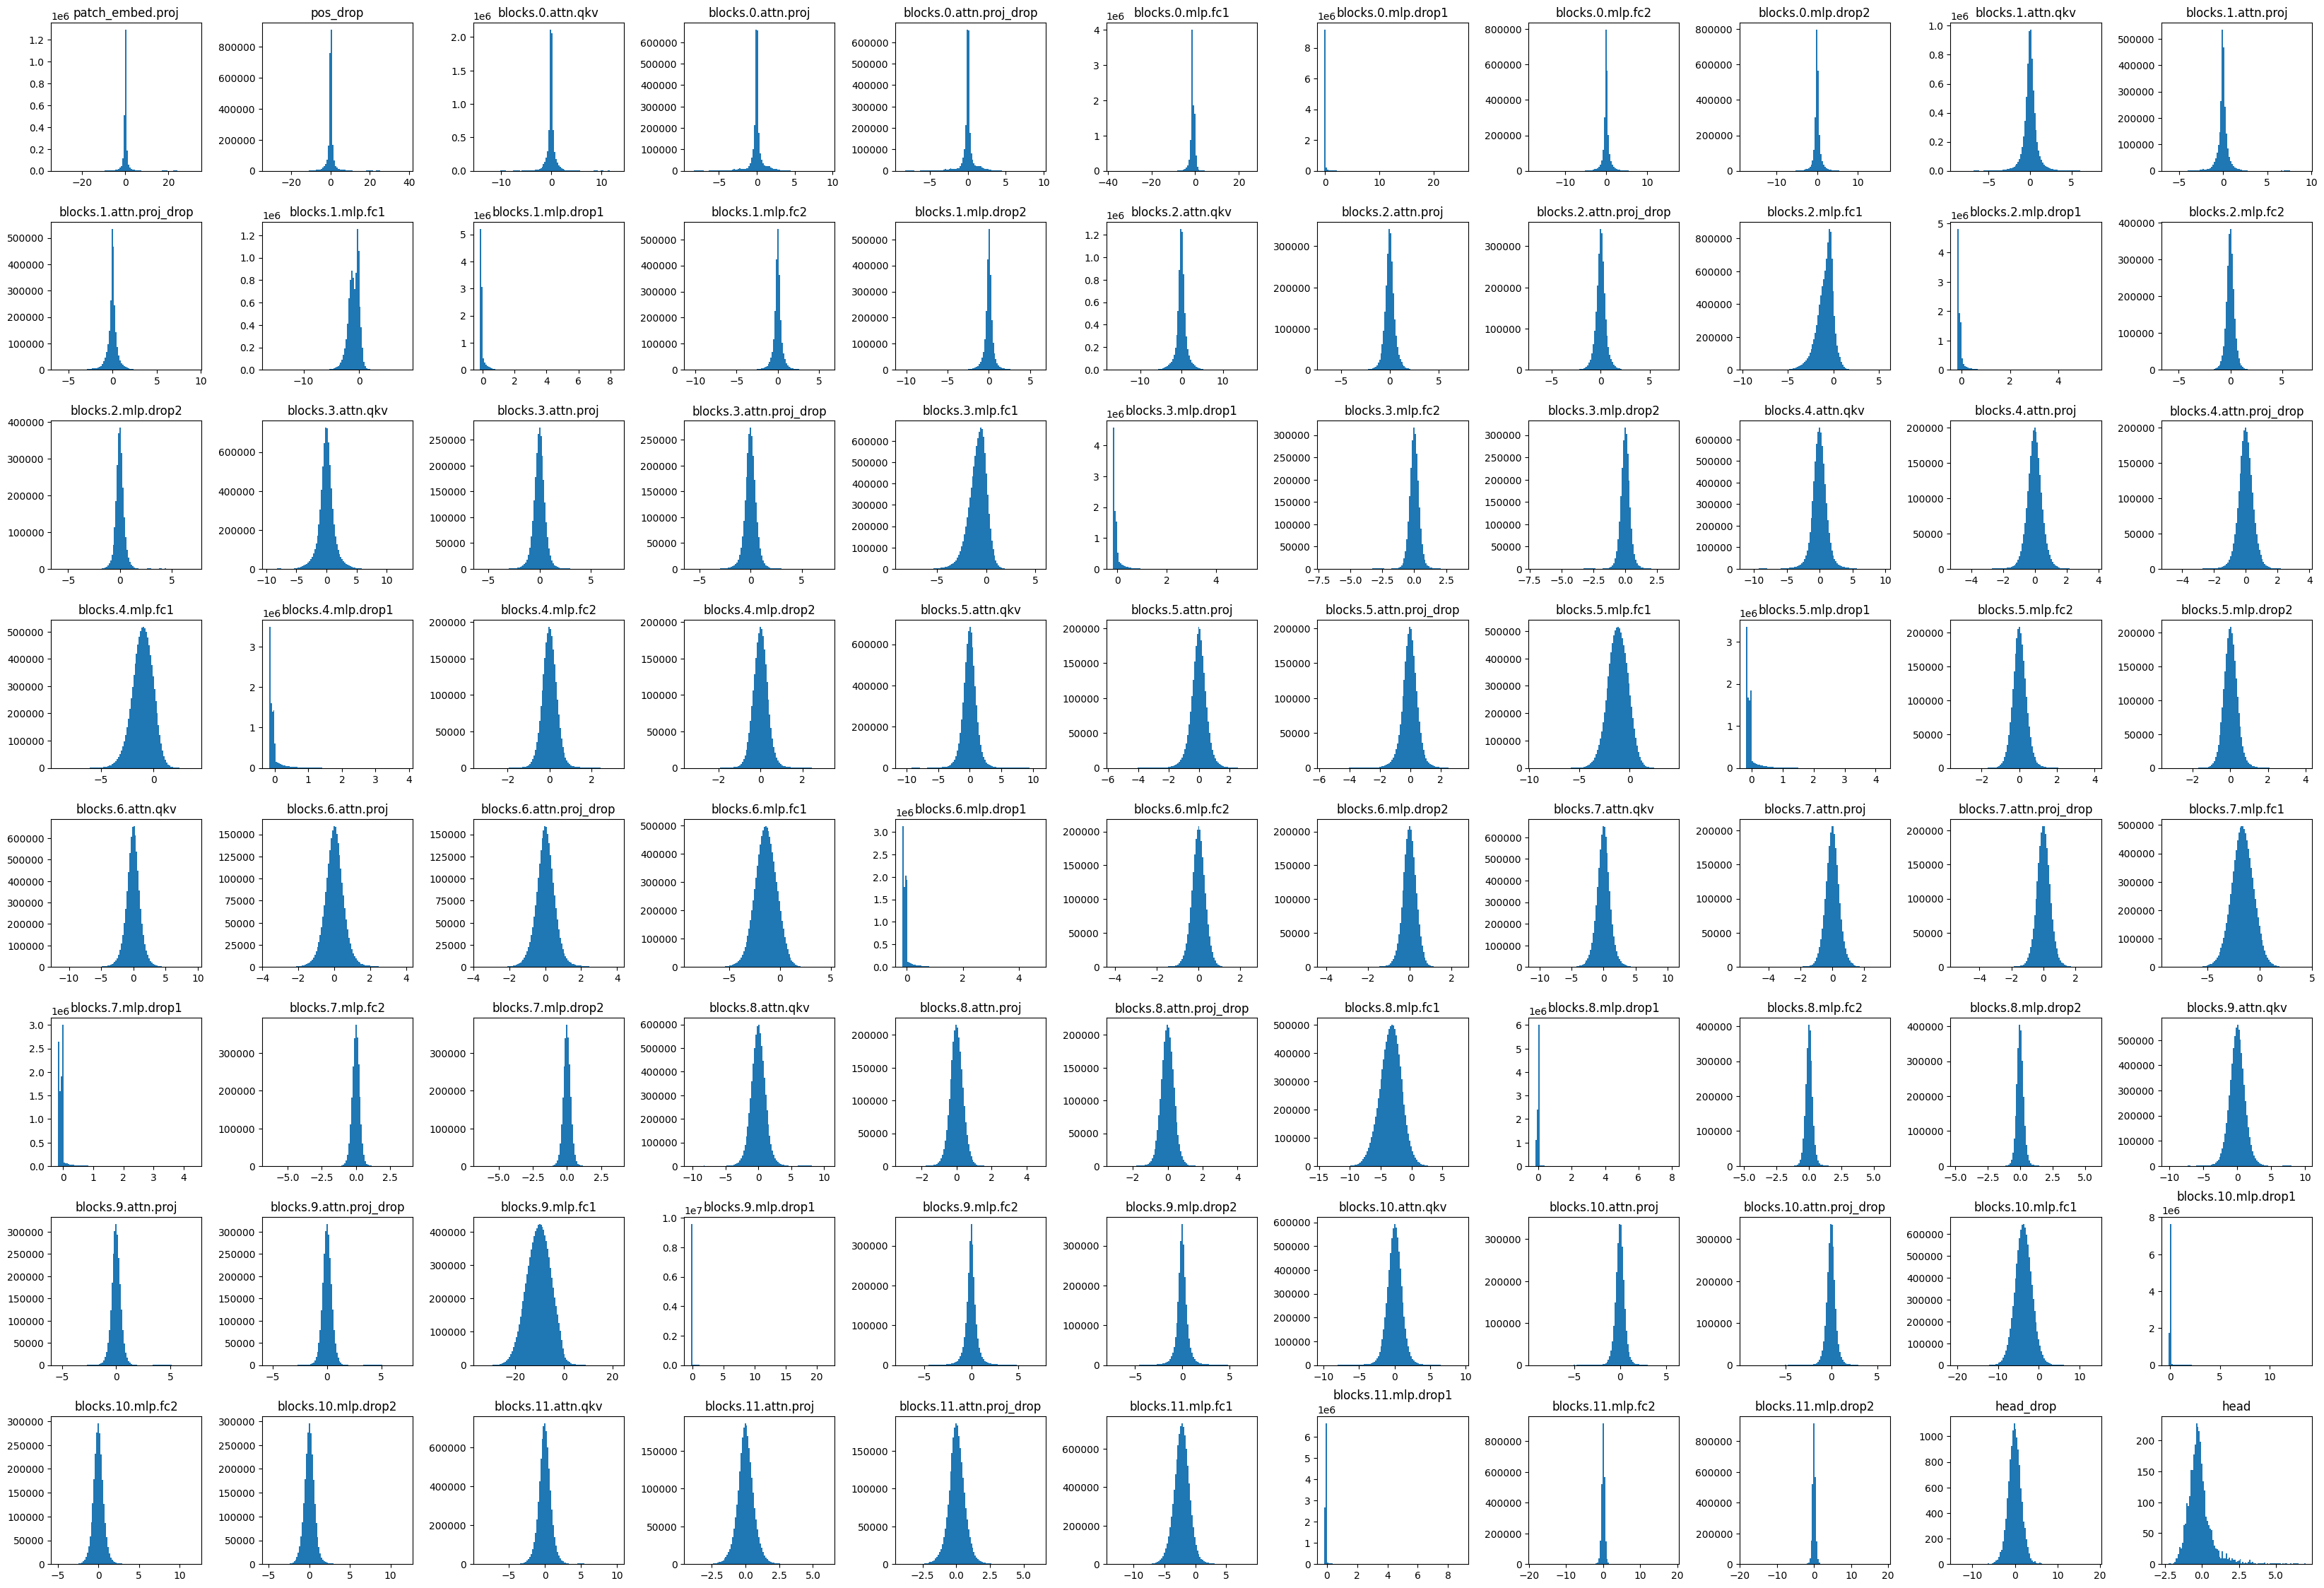

In [42]:
# initialize HookHandler and the dictionary to store the outputs
mobilenet = torch.load('0.9099_deit3_small_patch16_224.pth')
handler = HookHandler()
layer_outputs = {}

# get the layers you want to record
# layer_names = [f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2']
layer_names = [name for name, _ in mobilenet.named_modules()][1:]
print(layer_names)
block0_layers = get_model_layers(mobilenet, match_names=layer_names, match_types=['Conv2d', 'BatchNorm2d', 'ReLU6', 'Dropout', 'Linear'])

# create hooks for the layers (<layers>, <hook function>, <dictionary to store the outputs>)
handler.create_hooks(block0_layers, get_act_func, layer_outputs)

# calibrate the model and record the outputs
mobilenet.cpu()
with torch.autocast(device_type="cuda"):
    for i, (image, _) in enumerate(train_loader):
        if i >= 128: break
        mobilenet(image)

# remove the hooks
handler.remove_hooks()

plot_layer_output_dist(layer_outputs)
# plot_layer_output_minmax(layer_outputs)

In [40]:
def extract_weights(model):
    weights = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights[name] = param.detach().cpu().numpy().flatten()
    return weights

def plot_weight_statistics(weight_ranges, weight_stddevs):
    labels = list(weight_ranges.keys())
    range_values = list(weight_ranges.values())
    stddev_values = list(weight_stddevs.values())

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(14, 7))
    rects1 = ax.bar(x - width/2, range_values, width, label='Range', color='blue')
    rects2 = ax.bar(x + width/2, stddev_values, width, label='Standard Deviation', color='red')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Value')
    ax.set_title('Bar chart of Weight Range and Standard Deviation')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()

    fig.tight_layout()
    plt.show()

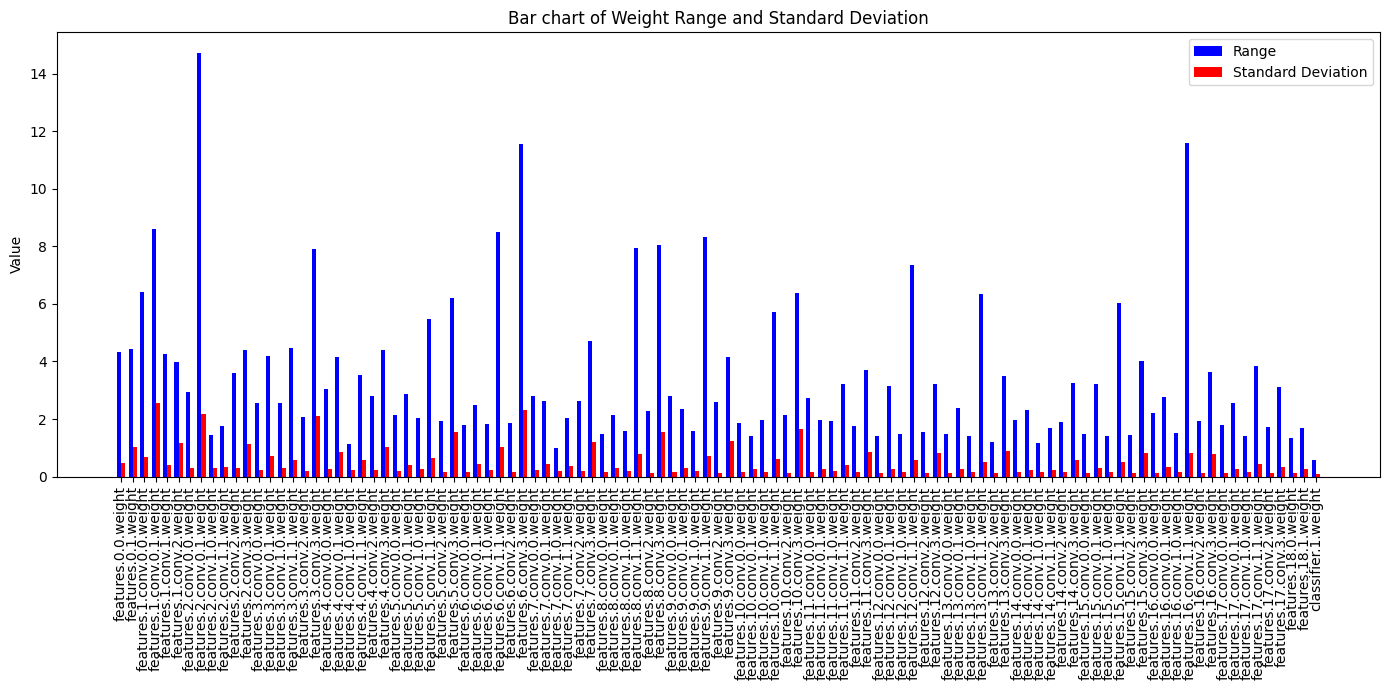

In [43]:
# Load the model
model = torch.load('mobilenetv2_0.963.pth', map_location='cpu')

# Extract weights
weights = extract_weights(model)

# Calculate the range and standard deviation for each layer's weights
weight_ranges = {}
weight_stddevs = {}

for name, weight in weights.items():
    weight_ranges[name] = np.ptp(weight)  # Range: max - min
    weight_stddevs[name] = np.std(weight)  # Standard deviation

# Plot the weight statistics
plot_weight_statistics(weight_ranges, weight_stddevs)


Files already downloaded and verified
Files already downloaded and verified
Layer Name: , Layer Type: MobileNetV2
Layer Name: features, Layer Type: Sequential
Layer Name: features.0, Layer Type: Conv2dNormActivation
Layer Name: features.0.0, Layer Type: Conv2d
Layer Name: features.0.1, Layer Type: BatchNorm2d
Layer Name: features.0.2, Layer Type: ReLU6
Layer Name: features.1, Layer Type: InvertedResidual
Layer Name: features.1.conv, Layer Type: Sequential
Layer Name: features.1.conv.0, Layer Type: Conv2dNormActivation
Layer Name: features.1.conv.0.0, Layer Type: Conv2d
Layer Name: features.1.conv.0.1, Layer Type: BatchNorm2d
Layer Name: features.1.conv.0.2, Layer Type: ReLU6
Layer Name: features.1.conv.1, Layer Type: Conv2d
Layer Name: features.1.conv.2, Layer Type: BatchNorm2d
Layer Name: features.2, Layer Type: InvertedResidual
Layer Name: features.2.conv, Layer Type: Sequential
Layer Name: features.2.conv.0, Layer Type: Conv2dNormActivation
Layer Name: features.2.conv.0.0, Layer Typ

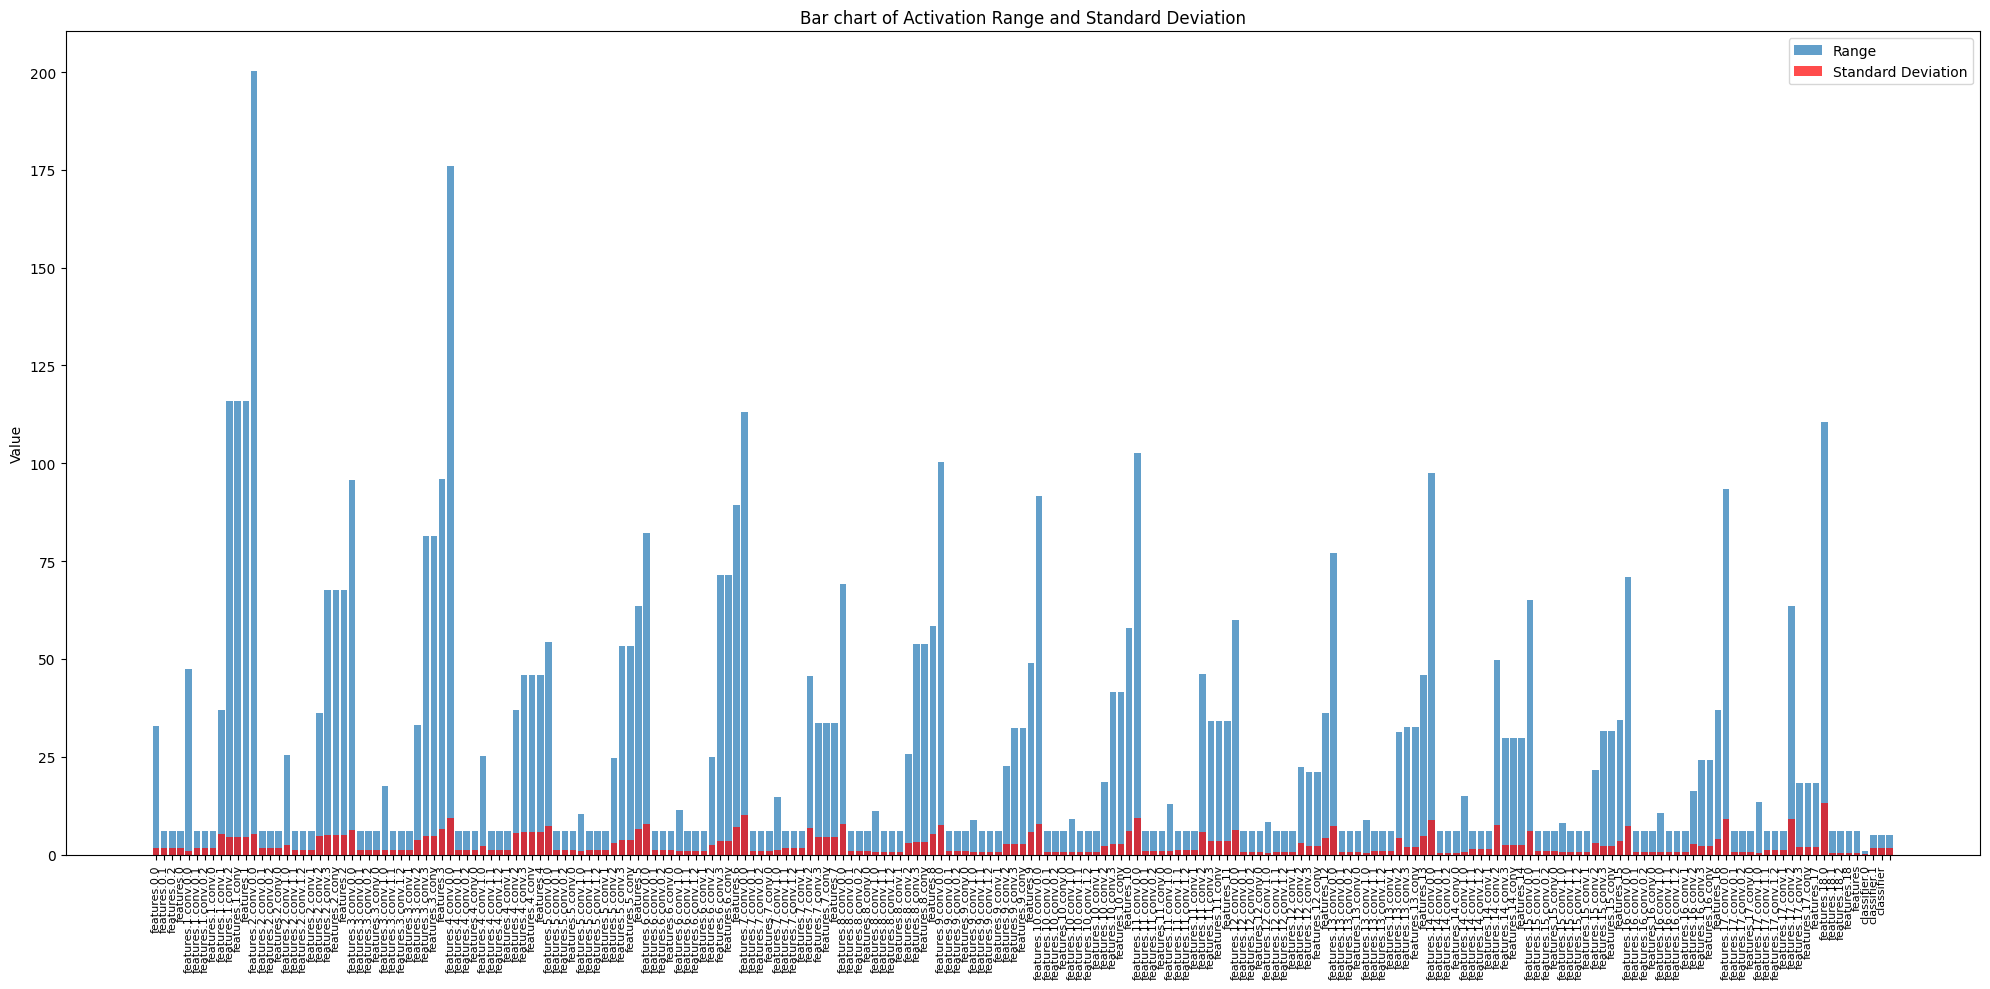

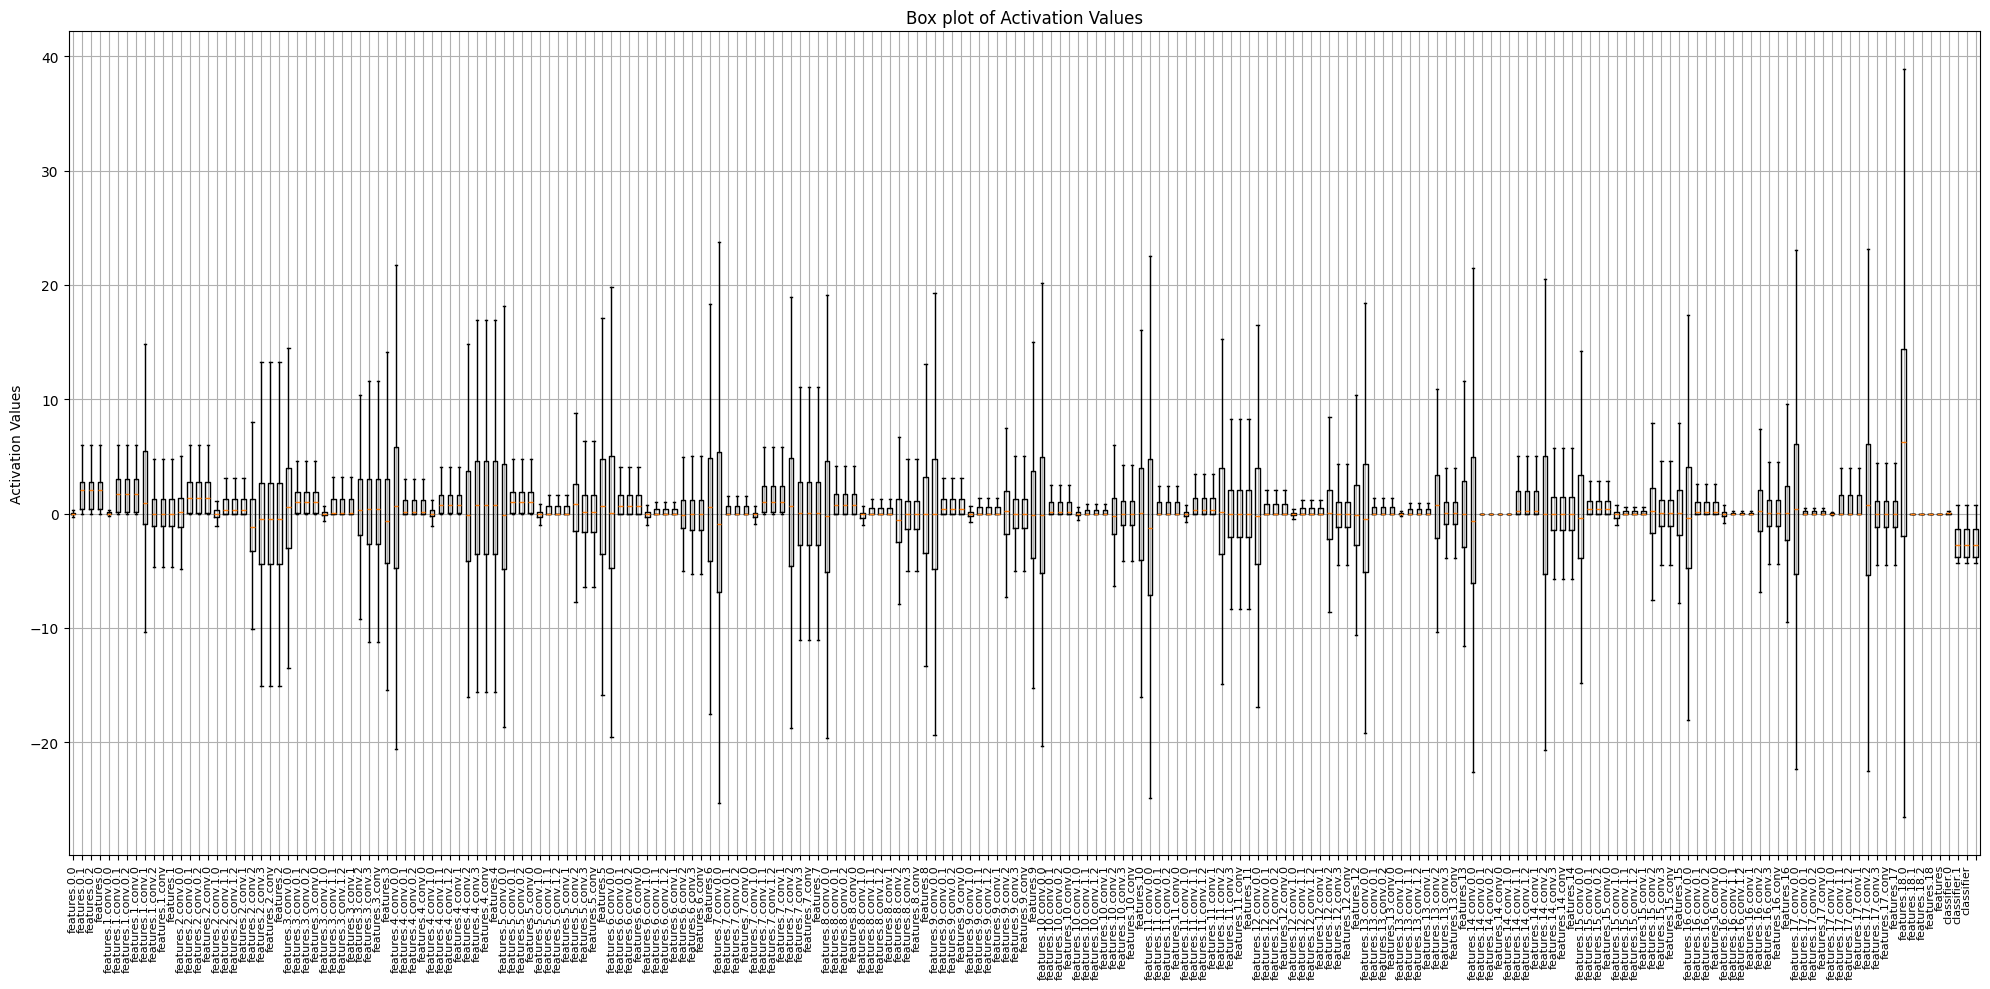

In [47]:
batch_size = 1
model = torch.load('mobilenetv2_0.963.pth', map_location='cpu')
train_loader, test_loader, nb_classes = prepare_data(batch_size)
for name, module in model.named_modules():
    print(f'Layer Name: {name}, Layer Type: {type(module).__name__}')
print('###########################################################')

# -------------------------------------------------------------------------
# initialize HookHandler and the dictionary to store the outputs
handler = HookHandler()
layer_outputs = {}

# get the layers you want to record
# layer_names = [f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2'
# block0_layers = get_model_layers(model, match_names=layer_names, match_types=['Linear'])
# # create hooks for the layers (<layers>, <hook function>, <dictionary to store the outputs>)
# handler.create_hooks(block0_layers, get_act_func, layer_outputs)


layers_of_interest = []

layers_of_interest = [(name, module) for name, module in model.named_modules()]
print(f'layers_of_interest: {layers_of_interest}')
for name, module in layers_of_interest:
    print(f'Layer Name: {name}, Layer Type: {type(module).__name__}')
print(f'layers_of_interest: {layers_of_interest}')
handler.create_hooks(layers_of_interest, get_act_func, layer_outputs)
model.eval()

# calibrate the model and record the outputs
with torch.autocast(device_type="cuda"):
    for i, (image, _) in enumerate(train_loader):
        if i >= 128: break
        model(image)

# remove the hooks
handler.remove_hooks()

print(f'######## Original Model Activation output')
for layer_name, activations in layer_outputs.items():
    print(f"Layer: {layer_name}, Data: {activations}")
    
# Now analyze the activations
activation_ranges = {}
activation_stddevs = {}

for layer_name, act in layer_outputs.items():
    activation_ranges[layer_name] = abs(act.max() - act.min())
    activation_stddevs[layer_name] = act.std()

# Plot the results for visual analysis
plt.figure(figsize=(20, 10))  # Increase figure size for better readability
plt.bar(activation_ranges.keys(), activation_ranges.values(), alpha=0.7, label='Range')
plt.bar(activation_stddevs.keys(), activation_stddevs.values(), alpha=0.7, label='Standard Deviation', color='r')
plt.ylabel('Value')
plt.title('Bar chart of Activation Range and Standard Deviation')
plt.xticks(rotation=90, fontsize=8)  # Adjust font size for better readability
plt.legend()
plt.tight_layout()
plt.show()

# Box plot for activation distribution
data = [activation.flatten() for activation in layer_outputs.values()]  # Flatten all activations
labels = list(layer_outputs.keys())

plt.figure(figsize=(20, 10))  # Increase figure size for better readability
plt.boxplot(data, labels=labels, showfliers=False)  # showfliers=False will not show any outliers
plt.xticks(rotation=90, fontsize=8)  # Adjust font size for better readability
plt.title('Box plot of Activation Values')
plt.ylabel('Activation Values')
plt.grid(True)
plt.tight_layout()
plt.show()